In [82]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to c:\users\asus\appdata\local\temp\pip-req-build-060bukj3
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git 'C:\Users\ASUS\AppData\Local\Temp\pip-req-build-060bukj3'


In [83]:
import os
import clip
import shutil
from PIL import Image
import matplotlib.pyplot as plt
from transformers import CLIPTokenizer
import torchvision.transforms as transforms

In [84]:
import torch

# Check if CUDA is available
cuda_available = torch.cuda.is_available()

if cuda_available:
    print("CUDA is available! Running on GPU.")
else:
    print("CUDA is not available. Running on CPU.")


CUDA is available! Running on GPU.


In [85]:
class CLIP_Model:
    _instance = None

    def __new__(cls):
        if cls._instance is None:
            # Instantiate the CLIP model only once
            cls._instance = super(CLIP_Model, cls).__new__(cls)
            cls.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            cls.model, cls.preprocessor = clip.load("ViT-B/32", device=cls.device)
        return cls._instance

    @classmethod
    def get_model(cls):
        """Returns the CLIP model and preprocessor."""
        if cls._instance is None:
            cls()  # Ensure instance is created
        return cls._instance.model, cls._instance.preprocessor

In [86]:
class GALIP_CONTAINER:
    def __init__(self, netG, netD, netC, text_encoder, image_encoder, optimizerG, optimizerD, scaler_G, scaler_D, device):
        self.netG = netG
        self.netD = netD
        self.netC = netC
        self.text_encoder = text_encoder
        self.image_encoder = image_encoder
        self.optimizerG = optimizerG
        self.optimizerD = optimizerD
        self.scaler_G = scaler_G
        self.scaler_D = scaler_D
        self.device = device

In [87]:
import torch
from torch import nn

def initialize_gan_model(CLIP, 
                              ngf=64, 
                              nz=100, 
                              cond_dim=512, 
                              imsize=224, 
                              ch_size=3, 
                              mixed_precision=True, 
                              ndf=64, 
                              lr_g=0.0001, 
                              lr_d=0.0004, 
                              betas=(0.0, 0.9)) -> GALIP_CONTAINER:

    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if torch.cuda.is_available():
        netG = nn.DataParallel(NetG(ngf, nz, cond_dim, imsize, ch_size, mixed_precision, CLIP))
        netD = nn.DataParallel(NetD(ndf, imsize, ch_size, mixed_precision))
        netC = nn.DataParallel(NetC(ndf, cond_dim, mixed_precision))
    else:
        netG = NetG(ngf, nz, cond_dim, imsize, ch_size, mixed_precision, CLIP)
        netD = NetD(ndf, imsize, ch_size, mixed_precision)
        netC = NetC(ndf, cond_dim, mixed_precision)
    
    # Initialize text and image encoders
    text_encoder = CLIP_TXT_ENCODER(CLIP)
    image_encoder = CLIP_IMG_ENCODER(CLIP)
    
    # Move models to device and set precision
    netG.float().to(device)
    netD.float().to(device)
    netC.float().to(device)
    
    # Initialize optimizers
    D_params = list(netD.parameters()) + list(netC.parameters())
    optimizerG = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=betas)
    optimizerD = torch.optim.Adam(D_params, lr=lr_d, betas=betas)
    
    # Initialize scalers for mixed precision training
    scaler_G =  torch.amp.GradScaler(device) 
    scaler_D =  torch.amp.GradScaler(device) 
    #     torch.amp.GradScaler('cuda')

    # Return the models, encoders, optimizers, and scalers
    return GALIP_CONTAINER (
        netG,
        netD,
        netC,
        text_encoder,
        image_encoder,
        optimizerG,
        optimizerD,
        scaler_G,
        scaler_D,
        device
    )

# Example usage:
CLIP,_ = CLIP_Model.get_model()  # Assuming CLIP model is defined elsewhere
galip_container = initialize_gan_model(CLIP)


In [88]:
def load_model_galip(components, load_path):
    checkpoint = torch.load(load_path, map_location=torch.device(components.device))
    
    # Loading model components
    components.netG.load_state_dict(checkpoint['model']['netG'], strict=False)
    components.netD.load_state_dict(checkpoint['model']['netD'], strict=False)
    components.netC.load_state_dict(checkpoint['model']['netC'], strict=False)
    components.text_encoder.load_state_dict(checkpoint['model']['text_encoder'], strict=False)
    components.image_encoder.load_state_dict(checkpoint['model']['image_encoder'], strict=False)

    # Loading optimizers
    components.optimizerG.load_state_dict(checkpoint['optimizers']['optimizer_G'])
    components.optimizerD.load_state_dict(checkpoint['optimizers']['optimizer_D'])
    
    return checkpoint['epoch']


In [89]:
epoch = load_model_galip(galip_container, 'AC_120_001.pth')

C:\Users\ASUS\AppData\Local\Temp\ipykernel_20220\968461972.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(load_path, map_location=torch.device(c

In [90]:
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

In [91]:
def test_model(galip_obj, input_ids, device, caption,z_dim=100 ,num_samples=10,upscale_size=(512, 512)):
    galip_obj.netG.eval()  # Set the generator to evaluation mode
    transform = transforms.ToPILImage()  # Convert the image tensor to PIL format
    save_dir = '/kaggle/working/generated_images/' + list(caption)[0]
    os.makedirs(save_dir, exist_ok=True)
    
    with torch.no_grad():  # No need to calculate gradients during testing
        for i in range(num_samples):
            # Generate random noise
            noise = torch.randn(1, z_dim).to(device)
            
            # Get caption embeddings using the text encoder
            caption_emb, word_embeds = galip_obj.text_encoder(input_ids)
            
            # Generate a fake image using the generator
            fake_image = galip_obj.netG(noise, caption_emb)
            
            # Assuming the generated image is normalized [-1, 1], denormalize it to [0, 1]
            fake_image = (fake_image.squeeze(0) * 0.5 + 0.5).clamp(0, 1)
            
            # Convert to PIL image and display
            pil_image = transform(fake_image.cpu())
            upscaled_image = pil_image.resize(upscale_size, Image.LANCZOS)
            image_path = os.path.join(save_dir, f"generated_image_{i+1}.png")
            pil_image.save(image_path)
            plt.imshow(upscaled_image)
            plt.title(f"Generated Image {i+1}")
            plt.axis('off')
            plt.show()

    # Zip the directory with generated images
    zip_path = '/kaggle/working/generated_images.zip'
    shutil.make_archive(zip_path.replace('.zip', ''), 'zip', save_dir)
    print(f"Images saved and zipped at: {zip_path}")

# Example usage:
# test_model(galip_obj, input_ids, device, caption)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_20220\1535968221.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast() if self.mixed_precision and not eval else dummy_context_mgr() as mp:


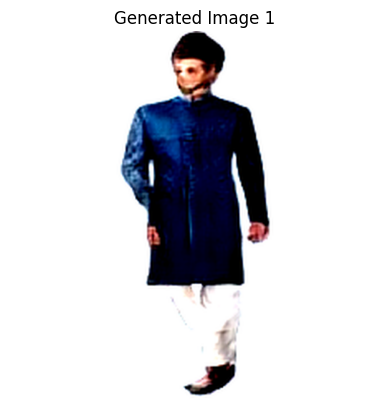

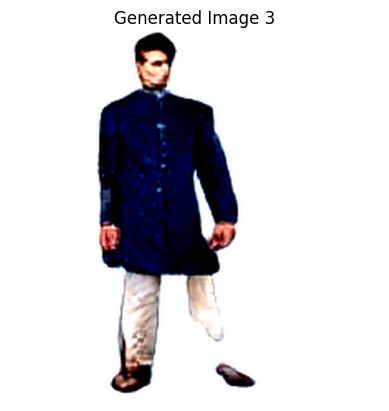

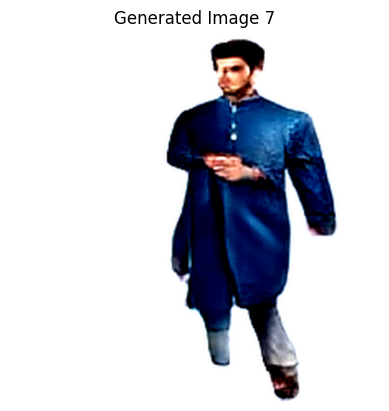

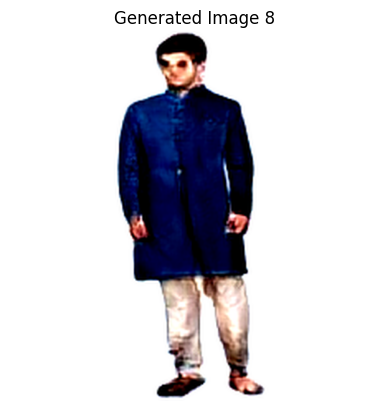

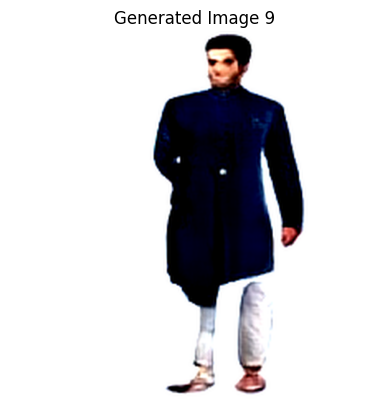

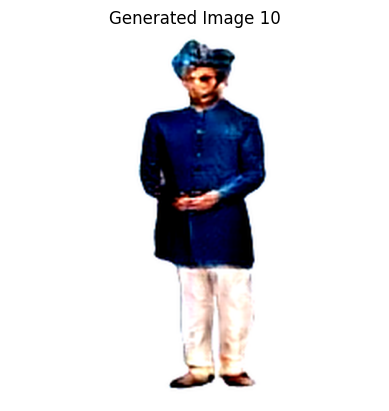

Images saved and zipped at: /kaggle/working/generated_images.zip


In [92]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
caption = "Blue Color Sherwani For Men's Jute, Linen"
tokens = tokenizer(caption, padding='max_length', truncation=True, max_length=77, return_tensors="pt")
input_ids = tokens.input_ids.to(device)
test_model(galip_container,input_ids, device,caption)